In [1]:
import torch
from torch import nn

import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pylab as plt


In [2]:
train_data = datasets.FashionMNIST(
    root = "data", 
    train= True,
    transform= ToTensor(),
    download= True,
    target_transform= None
)

test_data = datasets.FashionMNIST(
    root="data",
    train= False,
    transform= ToTensor(),
    download= True,
    target_transform= None
)

In [3]:
image, label = train_data[0]

image.shape , label

(torch.Size([1, 28, 28]), 9)

In [4]:
labels = train_data.classes
labels 

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# Prepare dataloader to load the data in batches so that
# GD is done in minibatches thus minibatch stocastic gradient descent
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)

In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [7]:
## building the model

# But first let's learn about flatten

# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [8]:
# I will not use hidden layers just to compare with my from scratch model
class FashionMNISTModelV0(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=out_shape)
        )
    
    def forward (self, X):
        return self.layer_stack(X)
    
model_0 = FashionMNISTModelV0(in_shape= 784, out_shape= len(labels))


In [9]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

accuracy_fn = Accuracy(task= "multiclass",
                       num_classes= len(labels))


/home/eren/.local/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [10]:
# Lets add progress bar YAY! ＼(＾▽＾)／

from tqdm.auto import tqdm

epochs = 10 

for epoch in tqdm(range(epochs)):
    
    
    model_0.train()
    train_loss = 0
    for X, y in train_dataloader:
        
        y_pred = model_0(X) 
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
    train_loss /= len(train_dataloader)
    

    test_loss =  test_acc = 0
    
    model_0.eval() 
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_preds = model_0(X)

            test_loss += loss_fn(test_preds, y)
            
            test_acc += accuracy_fn(y, test_preds.argmax(dim = 1))
            
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

        
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]


Train loss: 0.96709 | Test loss: 0.74001, Test acc: 0.76%

Train loss: 0.66918 | Test loss: 0.64663, Test acc: 0.79%

Train loss: 0.60451 | Test loss: 0.60436, Test acc: 0.80%

Train loss: 0.56939 | Test loss: 0.57761, Test acc: 0.81%

Train loss: 0.54635 | Test loss: 0.56030, Test acc: 0.81%

Train loss: 0.52954 | Test loss: 0.54670, Test acc: 0.82%

Train loss: 0.51693 | Test loss: 0.53676, Test acc: 0.82%

Train loss: 0.50631 | Test loss: 0.53058, Test acc: 0.82%

Train loss: 0.49804 | Test loss: 0.52017, Test acc: 0.82%

Train loss: 0.49087 | Test loss: 0.51711, Test acc: 0.82%


If we try to train with GPU the model would train slower,
this is because our dataset is kinda small so the GPU speed is outweighted by the time it takes to transfer the data there


Also you might wonder why we didn't use nonlinear functions?

Ironically, if we add non-linearities to our model it would perform worse than the baseline, 
and thats a thing you should always note in ML, 
that the thing you thought should work actually does not. 
and then the thing you thought might not work does.

Now Let's build a Convolutional Neural Network (CNN)

CNN's are known for thier capabilities to find pattens in visual data.

The CNN model we will build is known as *TinyVGG* it follows the typical structure of :

IN - > Conv Layer -> activation layer -> pooling layer

where the layers from [conv to pooling] layers can be upscalled and repeated.


This table is a good general guide for which model to use (though there are exceptions)

| **Problem type** | **Model to use (generally)** | **Code example** |
| ----- | ----- | ----- |
| Structured data (Excel spreadsheets, row and column data) | Gradient boosted models, Random Forests, XGBoost | [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), [XGBoost library](https://xgboost.readthedocs.io/en/stable/) |
| Unstructured data (images, audio, language) | Convolutional Neural Networks, Transformers | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) | 


For the Model architecture we will replicate [CNN Explainer website.](https://poloclub.github.io/cnn-explainer/)

In [11]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_unit):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_shape,
                out_channels=hidden_unit,
                kernel_size=3, 
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_unit,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_unit,hidden_unit, 3 , padding =1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit,hidden_unit,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features= hidden_unit * 7 * 7,
                out_features=out_shape)
        )
    
    def forward(self, X):
        return self.classifier(self.block2(self.block1(X)))
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1 = FashionMNISTModelV1(
    in_shape=1,
    out_shape=len(labels),
    hidden_unit=10).to(device)

model_1

FashionMNISTModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

How the heck does *MaxPooling2d*, *Relu*, and *Conv2d* work?

1. Conv2d:

This layer performs the convolution operation.
By Sliding a small matrix, called the *kernel* with a size `kernel_size` over the input data by steps of `stride`,
and calculate the dot product at each position, the results are then summed up.
This sum becomes a single pixel value in the output *Feature Map*

Conv2d could have multiple filters with different kernel weights,
each of them does the above operation and outputs It's own feature map.

2. Relu 

This simply applies the *ReLU* element wise, to introduce some non-linearity. The output of the $\text{ReLU}$ layer is a feature map that is sparse (contains many zeros) and only shows the positive evidence for a feature's presence.

3. MaxPool2D

As The name suggests this layer does *pool* over the ReLU-activated feature maps with a window or *kernel* of size `kernel_size` by steps of `stride`,
and return only the maximum of this kernel.

This max becomes a single element in the output.

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr = 0.01)

accuracy_fn = Accuracy(task= "multiclass",
                       num_classes= len(labels)).to(device)

In [13]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "cpu"):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y,
                                 y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = "cpu"):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y,
                test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [14]:
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0---------
Train loss: 1.56527 | Train accuracy: 0.44%
Test loss: 0.79187 | Test accuracy: 0.68%

Epoch: 1---------
Train loss: 0.64297 | Train accuracy: 0.77%
Test loss: 0.63919 | Test accuracy: 0.75%

Epoch: 2---------
Train loss: 0.53115 | Train accuracy: 0.81%
Test loss: 0.50108 | Test accuracy: 0.82%

Epoch: 3---------
Train loss: 0.47194 | Train accuracy: 0.83%
Test loss: 0.48626 | Test accuracy: 0.82%

Epoch: 4---------
Train loss: 0.43522 | Train accuracy: 0.84%
Test loss: 0.45117 | Test accuracy: 0.84%

Epoch: 5---------
Train loss: 0.40962 | Train accuracy: 0.85%
Test loss: 0.45521 | Test accuracy: 0.83%

Epoch: 6---------
Train loss: 0.39097 | Train accuracy: 0.86%
Test loss: 0.43549 | Test accuracy: 0.85%

Epoch: 7---------
Train loss: 0.37686 | Train accuracy: 0.87%
Test loss: 0.40405 | Test accuracy: 0.86%

Epoch: 8---------
Train loss: 0.36261 | Train accuracy: 0.87%
Test loss: 0.44607 | Test accuracy: 0.83%

Epoch: 9---------
Train loss: 0.35242 | Train accuracy:

In [15]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/157 [00:00<?, ?it/s]

In [16]:
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.4


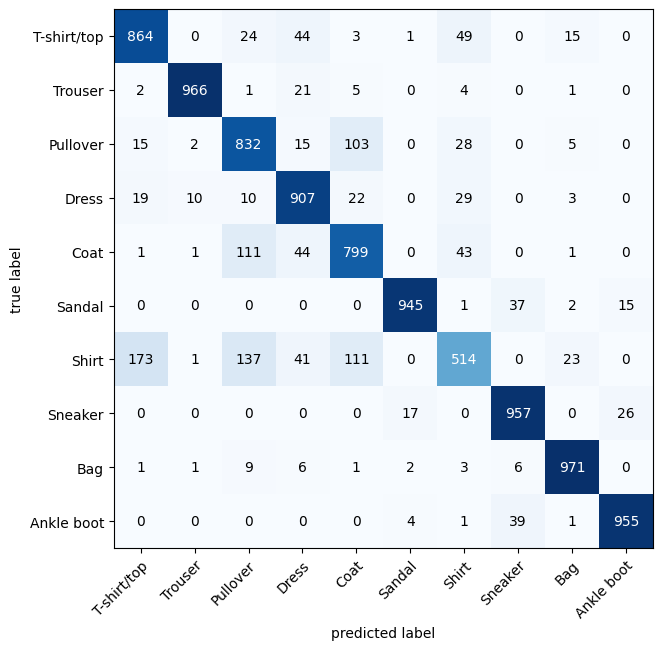

In [17]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(labels), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names= labels, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "CNN_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/CNN_FashionMNIST.pth
